In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.3 MB/s eta 0:00:00


In [3]:
!pip install prophet


In [4]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from prophet import Prophet
from pmdarima import auto_arima
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
import calendar
import pickle

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train1web.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
# Fill missing values
df = df.fillna(0)

In [ ]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [ ]:
# Setting 'Date' column as the index
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

## Time series analysis

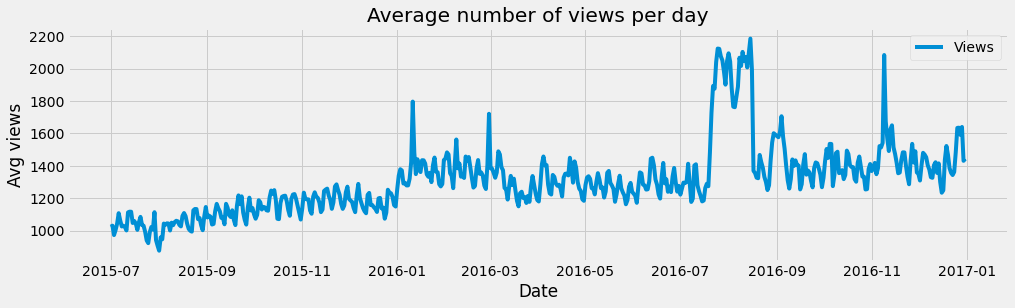

In [ ]:
# Average number of views per day
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp,label='Views')
plt.legend()
plt.show()

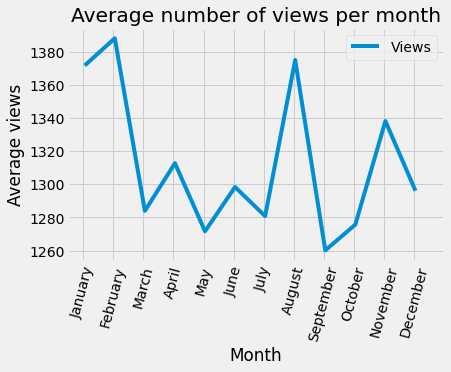

In [ ]:
# Average number of views per month
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
ax.set_title('Average number of views per month')
plt.show()

In [ ]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else:
        return 'none'
temp1 = df_reshaped
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'

temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

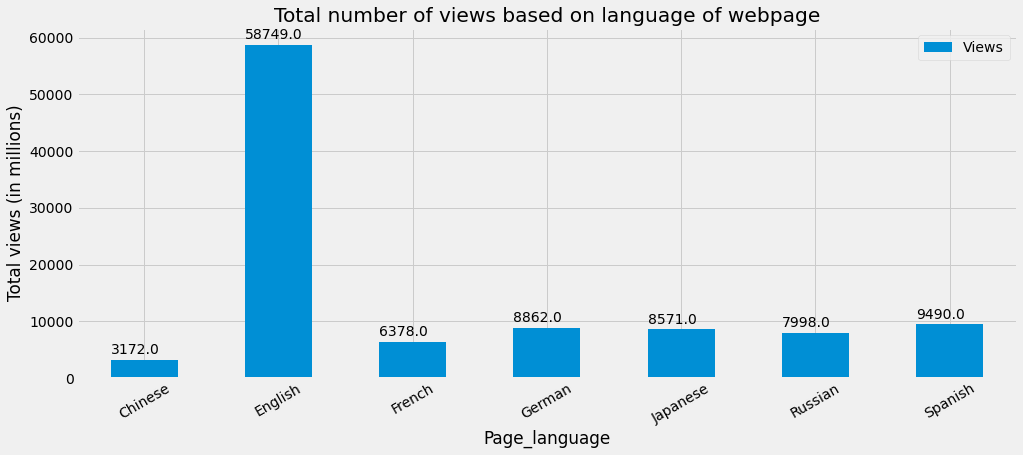

In [ ]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(15,6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language of webpage')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1000))
ax.legend()
plt.show()

In [ ]:
# Extracting day of week from date
days_df = df_reshaped.copy()
days_df = days_df[['Page','Views']]
days_df['Dayofweek'] = days_df.index.dayofweek

In [ ]:
def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'

days_df['Day'] = days_df.Dayofweek.apply(find_day)

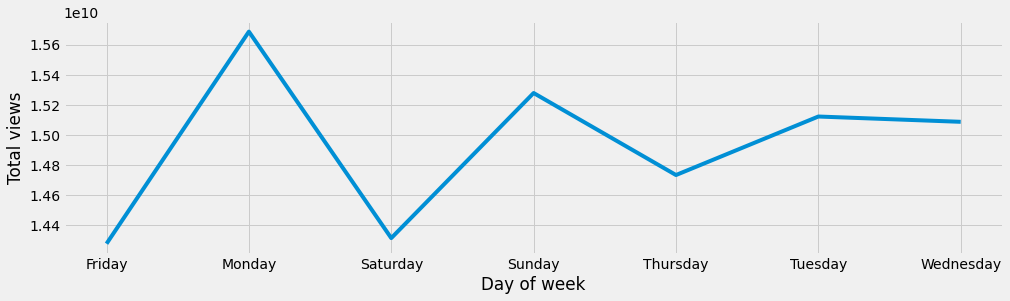

In [ ]:
day = days_df.groupby('Day')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [ ]:
# Top 5 pages with maximum number of views
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Views')['Page'].tolist()

In [ ]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(top_pages_list)]

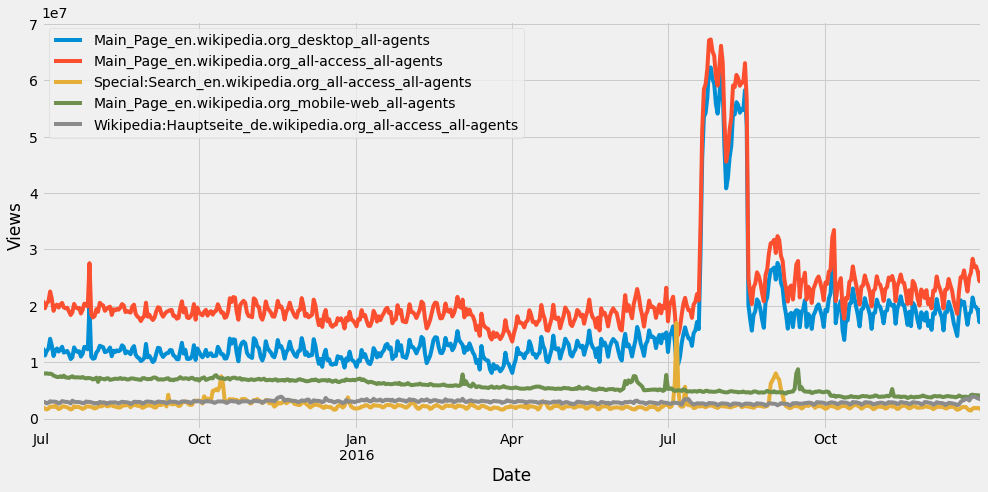

In [ ]:
# Plot with top 5 pages which have maximum number of views
fig, ax = plt.subplots(figsize=(15,7))
for i in list(top5_pages_df.Page.unique())[:5]:
    top5_pages_df.loc[top5_pages_df.Page == i].plot(ax=ax)

ax.set_ylabel('Views')
ax.legend(list(top5_pages_df.Page.unique())[:5],loc='upper left')
plt.show()

In [ ]:
# Time-series of page with maximum views
top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()
file_path = 'final_data.csv'

top_page_df.to_csv(file_path, index=False)



,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


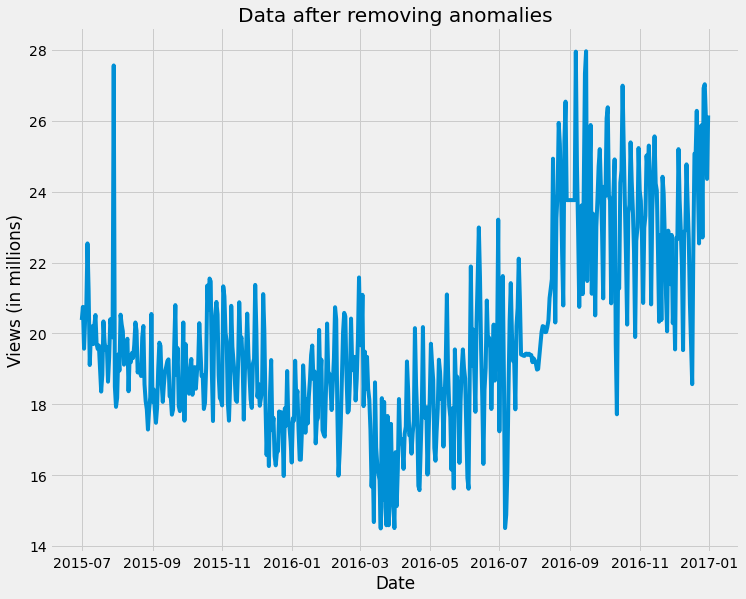

In [ ]:
# Filling missing data with rolling mean
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(11,9))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Data after removing anomalies')
plt.xlabel('Date')
plt.ylabel('Views (in millions)')
plt.show()

In [ ]:
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

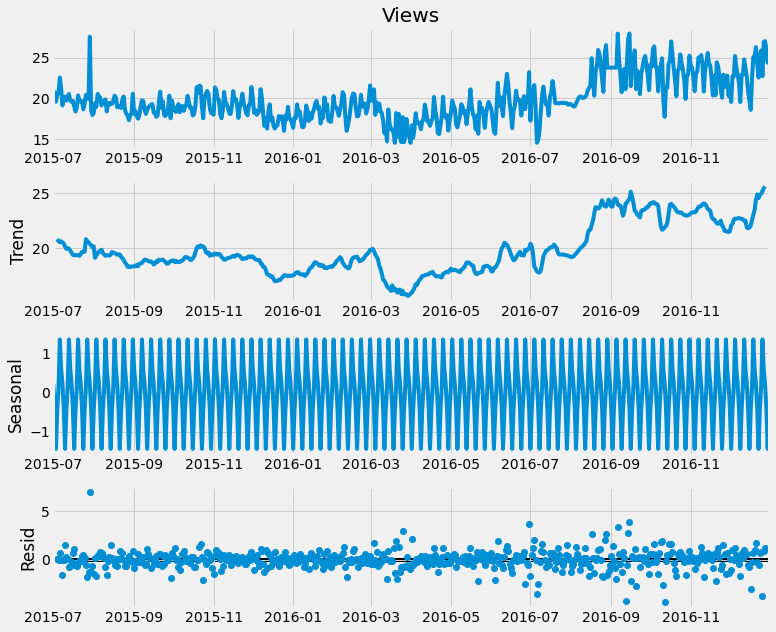

In [ ]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views)
figure = ts_decomposition.plot()

In [62]:
df = pd.read_csv('/content/drive/MyDrive/final_data.csv', parse_dates=['Date'], dayfirst=True, infer_datetime_format=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
df.head()


,Date,Views
0,2015-01-07,20.38
1,2015-02-07,20.75
2,2015-03-07,19.57
3,2015-04-07,20.44
4,2015-05-07,20.77


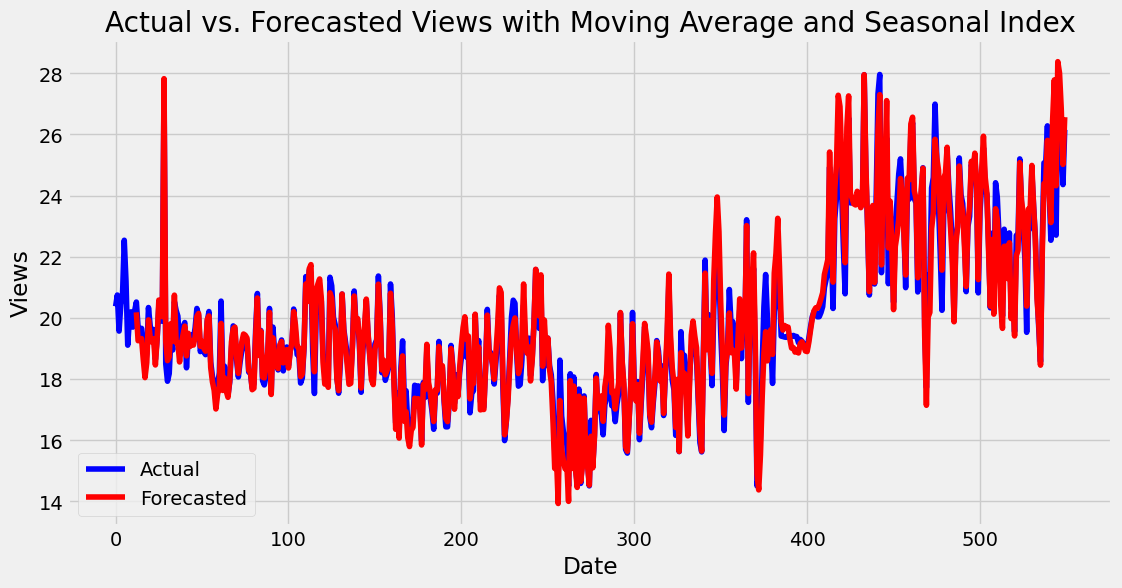

Mean Squared Error (MSE): 0.24
Root Mean Squared Error (RMSE): 0.49
Average Mean Squared Error (AvgMSE): 0.24
Mean Absolute Percentage Error (MAPE): 1.77%


In [8]:
# Define a function to calculate the seasonal index
def calculate_seasonal_index(data, period_length):
    seasonal_index = []
    for i in range(len(data)):
        if i < period_length:
            seasonal_index.append(np.nan)
        else:
            seasonal_index.append(data[i] / np.mean(data[i - period_length:i]))
    return seasonal_index

# Set the period length for seasonal index calculation
period_length = 12  # Adjust this based on the data frequency (e.g., 12 for monthly data over a year)

# Calculate the seasonal index
df['Seasonal_Index'] = calculate_seasonal_index(df['Views'], period_length)

# Define a function to apply the moving average using the seasonal index
def moving_average_with_seasonal_index(data, window_size, seasonal_index):
    smoothed_values = []
    for i in range(len(data)):
        if i < window_size:
            smoothed_values.append(np.nan)
        else:
            smoothed_value = np.mean(data[i - window_size:i]) * seasonal_index[i]
            smoothed_values.append(smoothed_value)
    return smoothed_values

# Set the window size for the moving average
window_size = 6  # Adjust this based on the desired moving average window

# Apply the moving average with seasonal index
df['Moving_Average'] = moving_average_with_seasonal_index(df['Views'], window_size, df['Seasonal_Index'])

# Calculate Percentage Error
df['Percentage_Error'] = ((df['Moving_Average'] - df['Views']) / df['Views']) * 100

# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Views'], label='Actual', color='blue')
plt.plot(df.index, df['Moving_Average'], label='Forecasted', color='red')
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Actual vs. Forecasted Views with Moving Average and Seasonal Index')
plt.legend()
plt.grid(True)
plt.show()

# Calculate MSE, RMSE, AvgMSE, and MAPE
moving_avg_mse = np.mean((df['Views'] - df['Moving_Average'])**2)
moving_avg_rmse = np.sqrt(moving_avg_mse)
moving_avg_avgmse = np.mean((df['Views'] - df['Moving_Average'])**2)
moving_avg_mape = np.mean(np.abs(df['Percentage_Error']))

print('Mean Squared Error (MSE): {:.2f}'.format(moving_avg_mse))
print('Root Mean Squared Error (RMSE): {:.2f}'.format(moving_avg_rmse))
print('Average Mean Squared Error (AvgMSE): {:.2f}'.format(moving_avg_avgmse))
print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(moving_avg_mape))

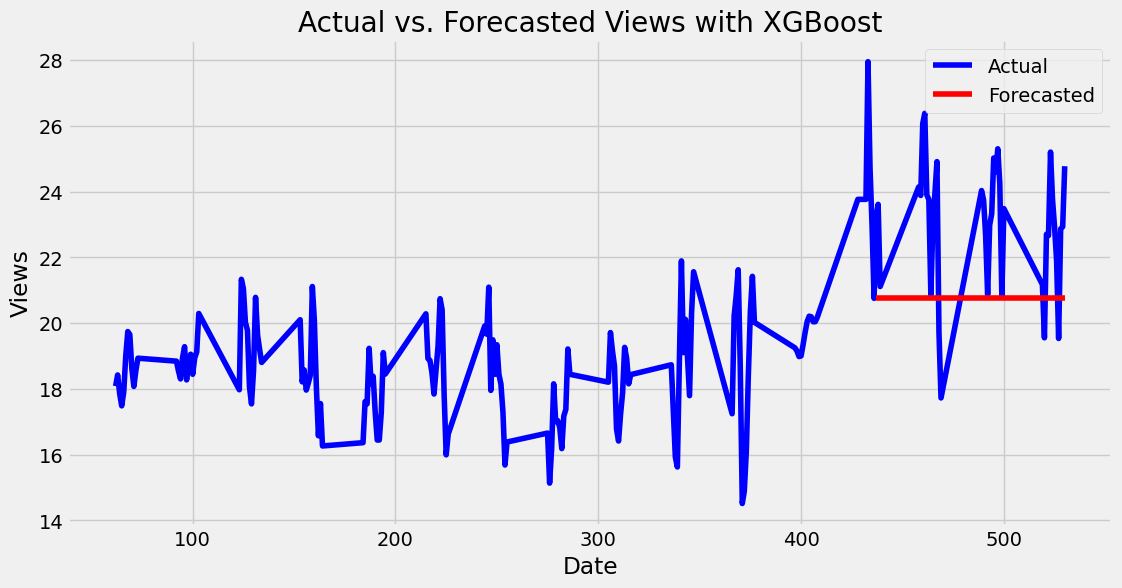

Mean Squared Error (MSE): 8.64
Root Mean Squared Error (RMSE): 2.94
Mean Absolute Percentage Error (MAPE): 10.94%
Average Mean Squared Error (AvgMSE): 8.64


In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Use the original 'Views' column as the target
y = df['Views']

# Create a numerical index as features for time series
df['Time'] = np.arange(len(df))
X = df[['Time']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)

# Add predictions to the dataframe
df.loc[X_test.index, 'Forecasted'] = y_pred

# Calculate Percentage Error
df['Percentage_Error'] = ((df['Forecasted'] - df['Views']) / df['Views']) * 100

# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Views'], label='Actual', color='blue')
plt.plot(df.index, df['Forecasted'], label='Forecasted', color='red')
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Actual vs. Forecasted Views with XGBoost')
plt.legend()
plt.grid(True)
plt.show()

xgboost_mse = mean_squared_error(y_test, y_pred)
xgboost_rmse = np.sqrt(xgboost_mse)
xgboost_mape = mean_absolute_percentage_error(y_test, y_pred)

# AvgMSE is essentially the same as MSE in this context
xgboost_avgmse = xgboost_mse

print('Mean Squared Error (MSE): {:.2f}'.format(xgboost_mse))
print('Root Mean Squared Error (RMSE): {:.2f}'.format(xgboost_rmse))
print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(xgboost_mape * 100))
print('Average Mean Squared Error (AvgMSE): {:.2f}'.format(xgboost_avgmse))

Mean Squared Error (MSE): 16.57
Root Mean Squared Error (RMSE): 4.07
Average Mean Squared Error (AvgMSE): 0.09
Mean Absolute Percentage Error (MAPE): 14.46%


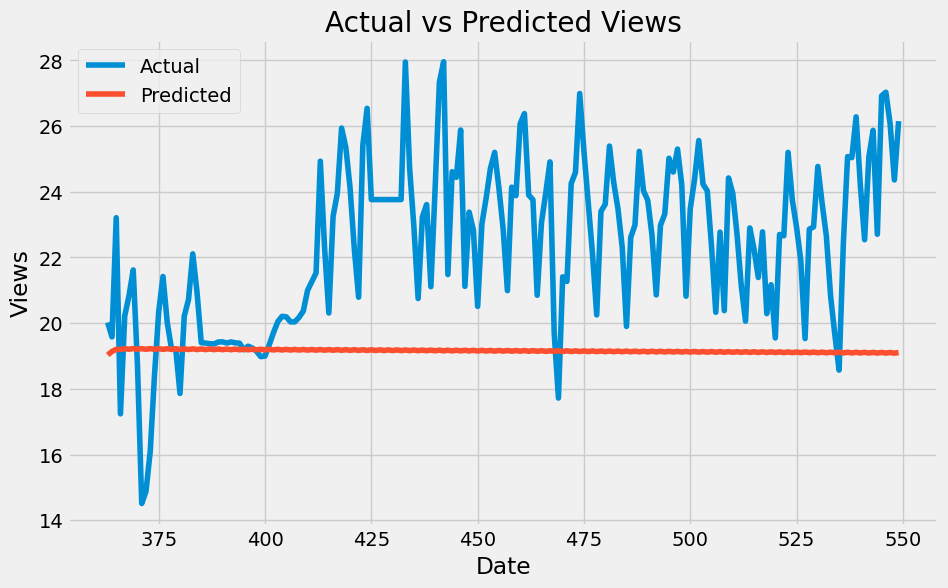

                                     SARIMAX Results                                     
Dep. Variable:                             Views   No. Observations:                  363
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 2)   Log Likelihood                -591.485
Date:                           Mon, 27 May 2024   AIC                           1190.971
Time:                                   13:43:30   BIC                           1206.515
Sample:                                        0   HQIC                          1197.152
                                           - 363                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3656      0.043      8.498      0.000       0.281       0.450
ma.L1         -0.9039      0.028    -31.933

In [65]:

# Define SARIMA model parameters
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 2)

# Define the size of the training and testing data
train_size = int(len(df) * 0.66)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit SARIMA model on the training data
model = SARIMAX(train['Views'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecast future values
forecast = model_fit.forecast(steps=len(test))

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Calculate MSE, RMSE, and AvgMSE
sarima_mse = mean_squared_error(test['Views'], forecast)
sarima_rmse = np.sqrt(sarima_mse)
sarima_avg_mse = sarima_mse / len(test)

print('Mean Squared Error (MSE): {:.2f}'.format(sarima_mse))
print('Root Mean Squared Error (RMSE): {:.2f}'.format(sarima_rmse))
print('Average Mean Squared Error (AvgMSE): {:.2f}'.format(sarima_avg_mse))
# Assign forecasted values to the DataFrame
test['Forecasted'] = forecast

# Calculate Percentage Error
test['Percentage_Error'] = ((test['Forecasted'] - test['Views']) / test['Views']) * 100

# Calculate MAPE
sarima_mape = np.mean(np.abs(test['Percentage_Error']))
print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(sarima_mape))

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Views'], label='Actual')
plt.plot(test.index, test['Forecasted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Actual vs Predicted Views')
plt.legend()
plt.show()

print(model_fit.summary())



Mean Squared Error (MSE): 19.81
Root Mean Squared Error (RMSE): 4.45
Average Mean Squared Error (AvgMSE): 0.30
Mean Absolute Percentage Error (MAPE): 10.94%


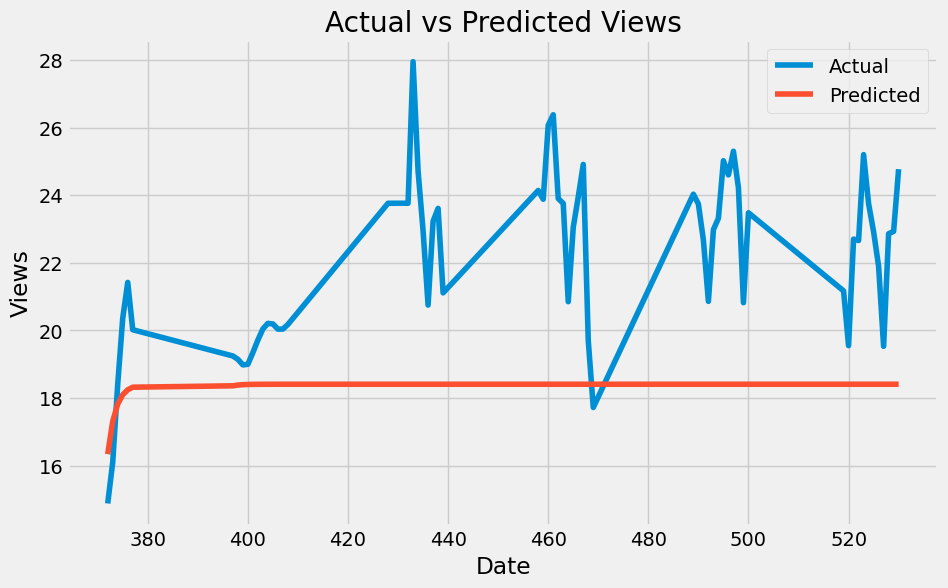

                               SARIMAX Results                                
Dep. Variable:                  Views   No. Observations:                  126
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -205.689
Date:                Mon, 27 May 2024   AIC                            417.379
Time:                        12:40:10   BIC                            425.864
Sample:                             0   HQIC                           420.826
                                - 126                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5309      0.078      6.833      0.000       0.379       0.683
ma.L1         -0.9994      0.534     -1.870      0.061      -2.047       0.048
sigma2         1.5285      0.838      1.824      0.0

In [25]:
# Define ARIMA model parameters
order = (1, 1, 1)

# Fit ARIMA model on the training data
model = ARIMA(train['Views'], order=order)
model_fit = model.fit()

# Forecast future values
forecast = model_fit.forecast(steps=len(test))

# Calculate MAPE
arima_mape = mean_absolute_percentage_error(test['Views'], forecast)


# Calculate MSE, RMSE, and AvgMSE
arima_mse = mean_squared_error(test['Views'], forecast)
arima_rmse = np.sqrt(arima_mse)
arima_avg_mse = arima_mse / len(test)

print('Mean Squared Error (MSE): {:.2f}'.format(arima_mse))
print('Root Mean Squared Error (RMSE): {:.2f}'.format(arima_rmse))
print('Average Mean Squared Error (AvgMSE): {:.2f}'.format(arima_avg_mse))

# Calculate Percentage Error
df['Percentage_Error'] = np.nan
mask = df['Views'] != 0
df.loc[mask, 'Percentage_Error'] = ((df.loc[mask, 'Forecasted'] - df.loc[mask, 'Views']) / df.loc[mask, 'Views']) * 100
df.loc[~mask, 'Percentage_Error'] = 0  # Set MAPE to 0 for cases where actual value is 0

# Calculate MAPE
mape = np.mean(np.abs(df['Percentage_Error']))
print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(mape))

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Views'], label='Actual')
plt.plot(test.index, forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Actual vs Predicted Views')
plt.legend()
plt.show()

print(model_fit.summary())


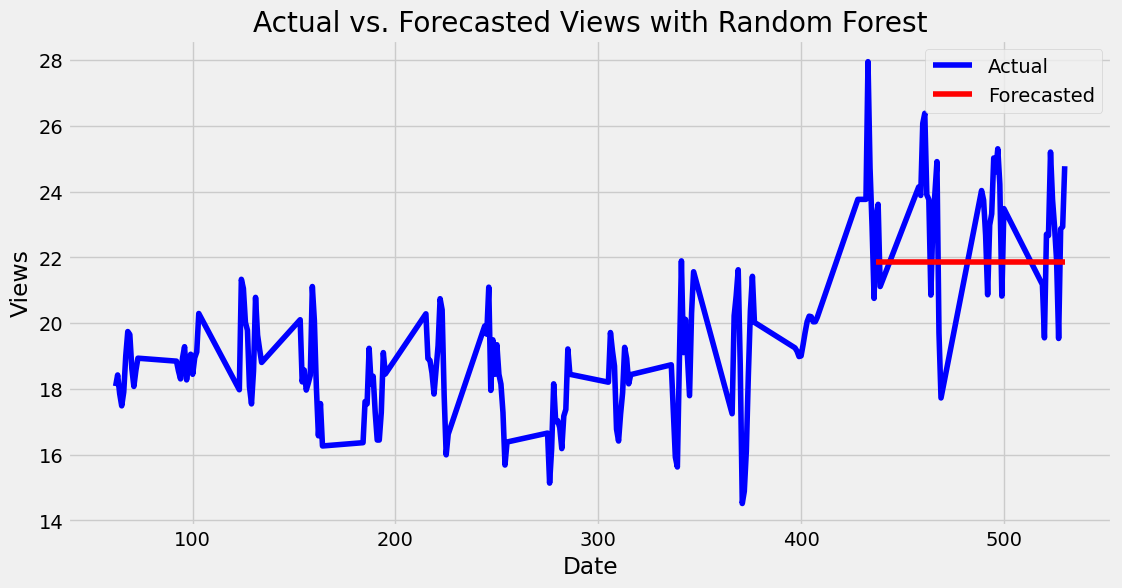

Mean Squared Error (MSE): 4.90
Root Mean Squared Error (RMSE): 2.21
Mean Absolute Percentage Error (MAPE): 8.40%
Average Mean Squared Error (AvgMSE): 4.90


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Use the original 'Views' column as the target
y = df['Views']

# Create a numerical index as features for time series
df['Time'] = np.arange(len(df))
X = df[['Time']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define and train the Random Forest model
model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)

# Add predictions to the dataframe
df.loc[X_test.index, 'Forecasted'] = y_pred

# Calculate Percentage Error
df['Percentage_Error'] = ((df['Forecasted'] - df['Views']) / df['Views']) * 100

# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Views'], label='Actual', color='blue')
plt.plot(df.index, df['Forecasted'], label='Forecasted', color='red')
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Actual vs. Forecasted Views with Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mape = mean_absolute_percentage_error(y_test, y_pred)
rf_avgmse = rf_mse

print('Mean Squared Error (MSE): {:.2f}'.format(rf_mse))
print('Root Mean Squared Error (RMSE): {:.2f}'.format(rf_rmse))
print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(rf_mape * 100))
print('Average Mean Squared Error (AvgMSE): {:.2f}'.format(rf_avgmse))


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    216 non-null    datetime64[ns]
 1   Views   550 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.7 KB


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5i_zk8h/670gs4e_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5i_zk8h/jv_crzo9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52265', 'data', 'file=/tmp/tmpj5i_zk8h/670gs4e_.json', 'init=/tmp/tmpj5i_zk8h/jv_crzo9.json', 'output', 'file=/tmp/tmpj5i_zk8h/prophet_modelixs3xod7/prophet_model-20240527132033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


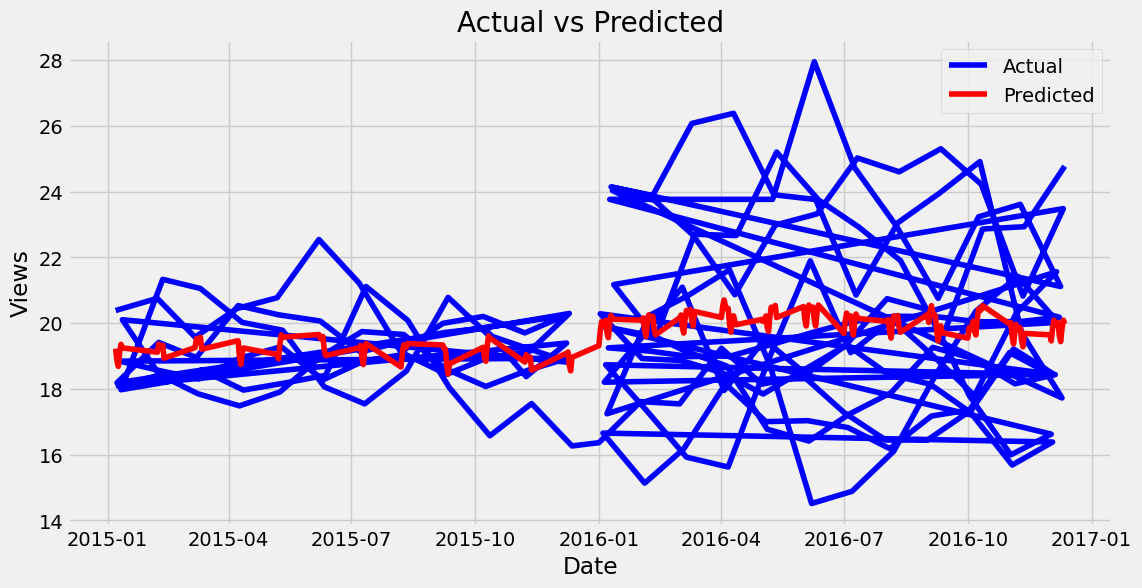

Mean Absolute Percentage Error (MAPE): 9.40%


In [48]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Drop rows with missing dates
df = df.dropna(subset=['Date'])

# Reset index to make the 'Date' column a regular column and rename columns for Prophet
df_prophet = df.rename(columns={'Date': 'ds', 'Views': 'y'})

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)

# Make predictions for all the data
forecast_all = model.predict(df_prophet)

# Plotting actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', color='blue')
plt.plot(forecast_all['ds'], forecast_all['yhat'], label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Mean Absolute Percentage Error (MAPE)
errors_all = forecast_all.set_index('ds').join(df_prophet.set_index('ds')['y']).dropna()
if not errors_all.empty:
    errors_all['absolute_error'] = abs(errors_all['yhat'] - errors_all['y'])
    errors_all['percentage_error'] = abs(errors_all['absolute_error'] / errors_all['y']) * 100
    mape = errors_all['percentage_error'].mean()
    print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
else:
    print("Error: No common timestamps between forecast and actual data.")


In [49]:
print(df.columns)

Index(['Date', 'Views'], dtype='object')


In [50]:
prophet_model = Prophet()
prophet_result = prophet_model.fit(train.reset_index().rename(columns={'Date':'ds','Views':'y'}))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5i_zk8h/0x9ohe5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5i_zk8h/8f31rxmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14060', 'data', 'file=/tmp/tmpj5i_zk8h/0x9ohe5l.json', 'init=/tmp/tmpj5i_zk8h/8f31rxmi.json', 'output', 'file=/tmp/tmpj5i_zk8h/prophet_model4xfuaths/prophet_model-20240527132336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


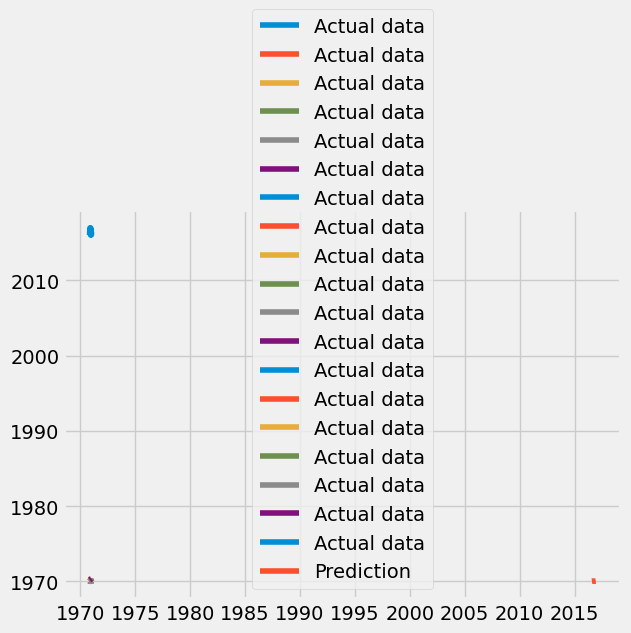

In [52]:
future = prophet_model.make_future_dataframe(periods=0)
prophet_prediction = prophet_model.predict(future)

prediction = prophet_prediction[['ds','yhat_lower','yhat_upper','yhat']][-30:]
plt.plot(train[-30:], label='Actual data')
plt.plot(prediction['ds'],prediction['yhat'],label='Prediction')
plt.fill_between(prediction['ds'],prediction['yhat_lower'],prediction['yhat_upper'],color='pink',alpha=0.5)
plt.legend(loc='best')
plt.show()

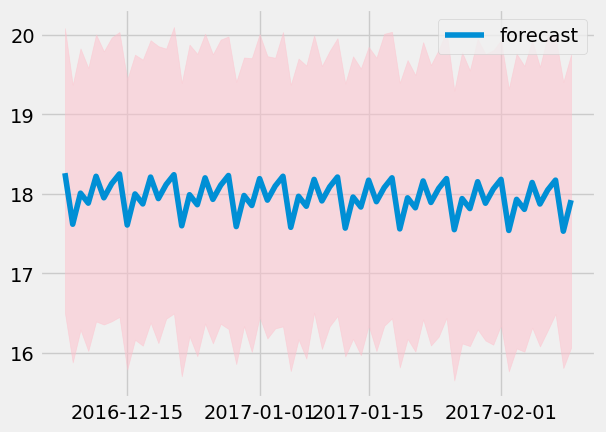

# Calculate Mean Squared Error (MSE) for Prophet
Prophet MSE: 23.44717141759427
# Calculate Root Mean Squared Error (RMSE) for Prophet
Prophet RMSE: 4.842227939450421
# Calculate Mean Absolute Percentage Error (MAPE) for Prophet
Prophet MAPE: 18.671702281815914


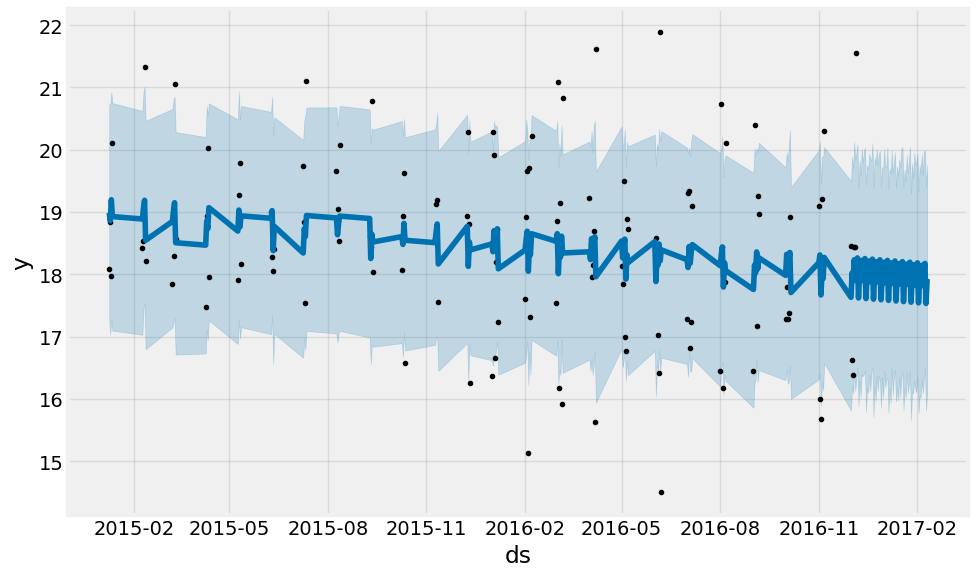

In [59]:
future = prophet_model.make_future_dataframe(periods=test.shape[0])
prophet_forecast = prophet_model.predict(future)

forecast = prophet_forecast[['ds','yhat_lower','yhat_upper','yhat']][-test.shape[0]:]
plt.plot(forecast['ds'],forecast['yhat'],label='forecast')
plt.fill_between(forecast['ds'],forecast['yhat_lower'],forecast['yhat_upper'],color='pink',alpha=0.5)
plt.legend(loc='best')
plt.show()

fig = prophet_model.plot(prophet_forecast)

import numpy as np

# Calculate Mean Squared Error (MSE) for Prophet
prophet_mse = np.mean(np.square(forecast.yhat.values - test.Views.values))

# Calculate Root Mean Squared Error (RMSE) for Prophet
prophet_rmse = np.sqrt(prophet_mse)

# Calculate Mean Absolute Percentage Error (MAPE) for Prophet
prophet_mape = np.mean(np.abs((forecast.yhat.values - test.Views.values) / test.Views.values)) * 100

print("# Calculate Mean Squared Error (MSE) for Prophet")
print("Prophet MSE:", prophet_mse)

print("# Calculate Root Mean Squared Error (RMSE) for Prophet")
print("Prophet RMSE:", prophet_rmse)

print("# Calculate Mean Absolute Percentage Error (MAPE) for Prophet")
print("Prophet MAPE:", prophet_mape)



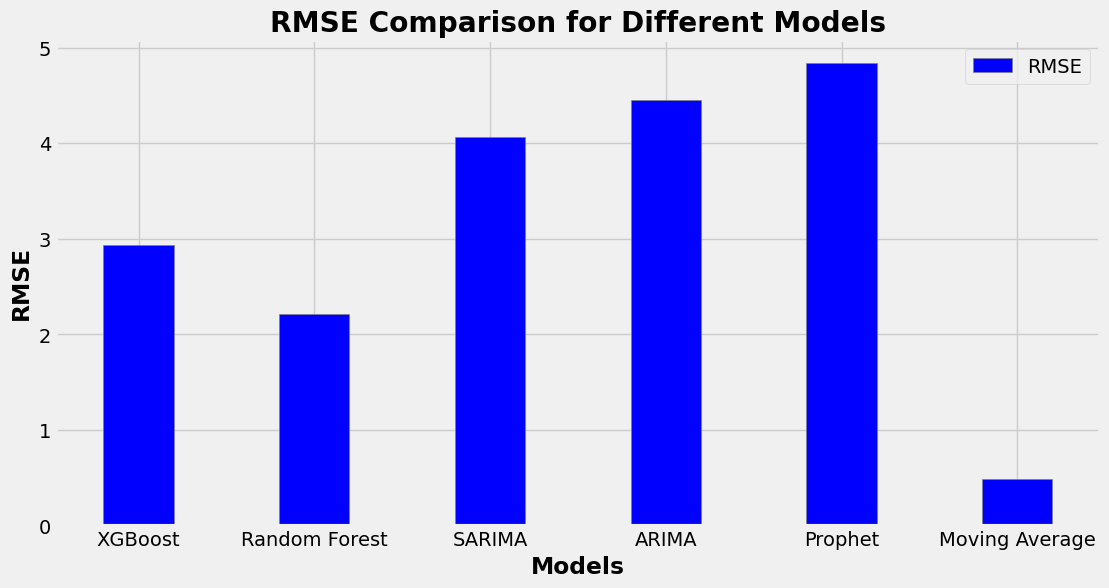

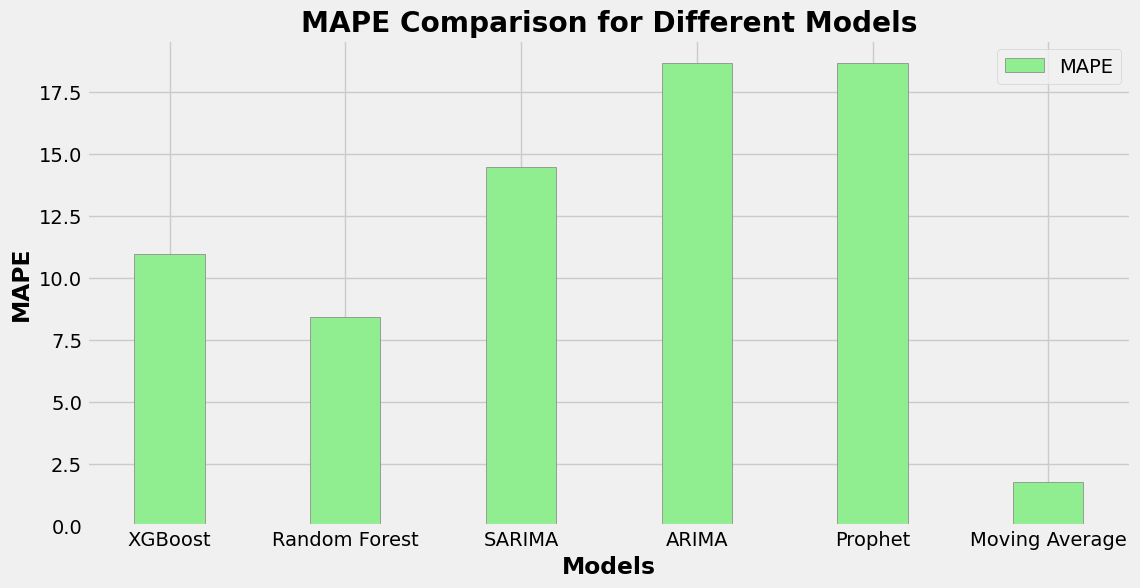

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics for each model
models = ['XGBoost', 'Random Forest', 'SARIMA', 'ARIMA', 'Prophet', 'Moving Average']
rmse_values = [xgboost_rmse, rf_rmse, sarima_rmse, arima_rmse, prophet_rmse, moving_avg_rmse]
mape_values = [xgboost_mape*100, rf_mape*100, sarima_mape, mape, prophet_mape, moving_avg_mape]

# Set width of bar
barWidth = 0.4

# Set position of bar on X axis
r1 = np.arange(len(models))

# Create bar plots for RMSE
plt.figure(figsize=(12, 6))
plt.bar(r1, rmse_values, color='blue', width=barWidth, edgecolor='grey', label='RMSE')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r for r in range(len(models))], models)

# Add ylabel
plt.ylabel('RMSE', fontweight='bold')

# Add title
plt.title('RMSE Comparison for Different Models', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()

# Create bar plots for MAPE
plt.figure(figsize=(12, 6))
plt.bar(r1, mape_values, color='lightgreen', width=barWidth, edgecolor='grey', label='MAPE')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r for r in range(len(models))], models)

# Add ylabel
plt.ylabel('MAPE', fontweight='bold')

# Add title
plt.title('MAPE Comparison for Different Models', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.show()
